In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf


/home/ashutosh/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
x=mnist.train.images.reshape(55000,28,28,1)
y=mnist.train.labels.reshape(55000,10)
x=x[:50,:,:]
y=y[:50,:]
print(x.shape)
y=y.T
m=y.shape[1]
print(y)

(50, 28, 28, 1)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [4]:
def batchn_forward(A,gamma,beta,eps):
    A_mu=np.mean(A,axis=0)
    inv_var=1.0/(np.var(A,axis=0))
    A_hat=(A-A_mu)/(np.sqrt(1.0/inv_var+eps))
    z=gamma*A_hat+beta
    cache2=A_mu, inv_var, A_hat, gamma
    return z,cache2

In [5]:
def batchn_backward(dout, cache):
    N, D = dout.shape
    A_mu, inv_var, A_hat, gamma = cache

    inv_var=np.sqrt(inv_var+.001)                                   
    dAhat = dout * gamma

    dA = (1.0 / N) * inv_var * (N*dAhat - np.sum(dAhat, axis=0) - A_hat*np.sum(dAhat*A_hat, axis=0))
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(A_hat*dout, axis=0)

    return dA, dgamma, dbeta

In [6]:
def zero_pad(X, pad):
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant')
     
    
    return X_pad

In [7]:
def conv_single_step(a_slice_prev, W, b):
    s =a_slice_prev*W
    
    Z = np.sum(s)
    
    Z = Z+np.float(b)
    

    return Z

In [8]:
def conv_forward(A_prev, W, b, hparameters):
     
    (m, n_H_prev, n_W_prev, n_C_prev) =A_prev.shape
    
     
    (f, f, n_C_prev, n_C) = W.shape
    
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    
    n_H = int((n_H_prev-f+2*pad)/stride) +1
    n_W = int((n_W_prev-f+2*pad)/stride) +1
    
     
    Z = np.zeros((m,n_H,n_W,n_C))
    
     
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                
        a_prev_pad = A_prev_pad[i]                         
        for h in range(n_H):                          
            for w in range(n_W):                       
                for c in range(n_C):                   
                     
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride 
                    horiz_end = horiz_start+f
                    
                     
                    a_slice_prev =a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    
                    Z[i, h, w, c] =conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
     
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [9]:
def pool_forward(A_prev, hparameters, mode = "max"):
     
     
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
     
    f = hparameters["f"]
    stride = hparameters["stride"]
    
     
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
     
    A = np.zeros((m, n_H, n_W, n_C))              
    
     
    for i in range(m):                          
        for h in range(n_H):                      
            for w in range(n_W):                  
                for c in range (n_C):             
                    
                     
                    vert_start =h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                     
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
     
    
    cache = (A_prev, hparameters)
    
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [10]:
def fc(A_prev,w,b,gamma,beta,eps):
    (m,hw) = A_prev.shape

     
    Z=np.dot(w,A_prev)+b
    
    ZT,cache2=batchn_forward(Z,gamma,beta,eps)
    cache_fc=(A_prev,w,b)
    return ZT,cache_fc,cache2

In [11]:
def softmax(Z):
    Z_exp=np.exp(Z)
    Z_sum=np.sum(Z_exp,axis=0)
    Z_sf=Z_exp/Z_sum
    
    
    
    return Z_sf

In [12]:
 def loss(predicted,y):
        m=y.shape[1]
        loss=-np.log(predicted)*y
         
        loss=(np.sum(loss))
          
        loss=loss/m
        return loss
    

In [13]:
def fc_backward(dZT,cache,cache2):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dZ, dgamma, dbeta=batchn_backward(dZT, cache2)
     
    dW = 1.0/m*(np.dot(dZ,A_prev.T))
    db = 1.0/m*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev,dW,db,dgamma,dbeta

In [14]:
def create_mask_from_window(x):
     
    
    
    mask = (x==np.max(x))
     
    
    return mask

def distribute_value(dz, shape):
     
    
     
    (n_H, n_W) = shape
    
    
    average = n_H*n_W
    
     
    a = np.ones(shape)*dz/average
     
    return a

def pool_backward(dA, cache, mode = "max"):
    
    (A_prev, hparameters) = cache
    
     
    stride = hparameters["stride"]
    f = hparameters["f"]
    
     
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
     
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                        
        
         
        a_prev = A_prev[i]
        
        for h in range(n_H):                   
            for w in range(n_W):                
                for c in range(n_C):            
                    
                    
                    vert_start = h
                    vert_end = h+f
                    horiz_start = w
                    horiz_end = w+f
                    
                    
                    if mode == "max":
                        
                         
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        
                        mask = create_mask_from_window(a_prev_slice)
                         
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask*dA[i,h,w, c]
                        
                    elif mode == "average":
                        
                         
                        da = dA[i,h,w,c]
                         
                        shape = (f,f)
                         
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                        
     
    
    
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev


In [15]:
 def conv_backward(dZ, cache):
     
    (A_prev, W, b, hparameters) = cache
    
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
     
    (f, f, n_C_prev, n_C) = W.shape
    
     
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
     
    (m, n_H, n_W, n_C) = dZ.shape
    
     
    dA_prev = np.zeros(A_prev.shape)                           
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

     
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                        
        
         
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                    
            for w in range(n_W):                
                for c in range(n_C):            
                    
                     
                    vert_start = h*pad
                    vert_end = h*pad+f
                    horiz_start = w*pad
                    horiz_end = w*pad+f
                    
                     
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                     
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
        
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [16]:
A_0=x
W_1=np.random.randn(3,3,1,3)*0.01
b_1=np.random.randn(1,1,1,3)
A_1,cache_1=conv_forward(A_0, W_1, b_1, hparameters={"stride":1,"pad":1})


In [17]:
A_2, cache_2= pool_forward(A_1, hparameters={"f":2,"stride":2}, mode = "max")
A_2=(A_2.reshape(50,588)).T

In [18]:
W_3=np.random.randn(10,588)*0.01
b_3=np.random.randn(10,1)
gamma=np.random.rand(10,1)
beta=np.random.rand(10,1)
eps=.0001
ZT_3,cache_3,cache2=fc(A_2, W_3, b_3,gamma,beta,eps)

 
A_3=softmax(ZT_3)
dZT_3=A_3-y

In [19]:
costs=[]


In [20]:
costs.append(loss(A_3, y))
temp_cost=loss(A_3, y)
change=1

In [21]:
for i in range(10):
    dA_2,dW_3,db_3,dgamma_3,dbeta_3=fc_backward(dZT_3, cache_3,cache2)
    
    dA_2=dA_2.T
    dA_2=dA_2.reshape(50,14,14,3)
    dA_1=pool_backward(dA_2, cache_2, mode = "max")
    dZ_1=dA_1
    dA_1,dW_1,db_1=conv_backward(dZ_1, cache_1)
    learning_rate=0.0001
    W_1=W_1-learning_rate*dW_1
    W_3=W_3-learning_rate*dW_3
    
    b_1=b_1-learning_rate*db_1
    b_3=b_3-learning_rate*db_3
    gamma=gamma-learning_rate*dgamma_3
    beta=beta-learning_rate*dbeta_3
    A_1,cache_1=conv_forward(A_0, W_1, b_1, hparameters={"stride":1,"pad":1})
    A_2, cache_2= pool_forward(A_1, hparameters={"f":2,"stride":2}, mode = "max")
    A_2=(A_2.reshape(50,588)).T
    Z_3,cache_3,cache2=fc(A_2, W_3, b_3,gamma,beta,eps)
    
    
 
    A_3=softmax(Z_3)
    cost=loss(A_3, y)
    costs.append(cost)
    change=temp_cost-cost
    temp_cost=cost
    
    print("{} epoch completed and cost is {}".format(i+1,cost))

1 epoch completed and cost is 2.50675597372
2 epoch completed and cost is 2.503634233
3 epoch completed and cost is 2.5005230765
4 epoch completed and cost is 2.49742306976
5 epoch completed and cost is 2.49433477138
6 epoch completed and cost is 2.49125878229
7 epoch completed and cost is 2.48819562358
8 epoch completed and cost is 2.48514590915
9 epoch completed and cost is 2.48211015013
10 epoch completed and cost is 2.47908891374


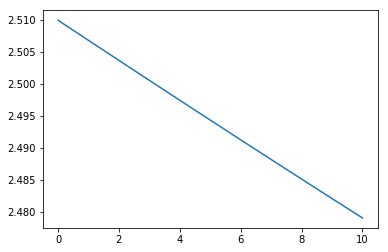

In [23]:
import matplotlib.pyplot as plt
plt.plot(costs)
plt.show()